# IMdB with HaGraD, backed by  <img src="https://upload.wikimedia.org/wikipedia/commons/1/10/PyTorch_logo_icon.svg" style="height:0.75em"/>PyTorch

---

### Setup

In [1]:
## Stuff from torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url

## Stuff from torchtext
from torchtext.datasets import IMDB
from torchtext.data import get_tokenizer
import torchtext.functional as F
import torchtext.vocab as ttv

## Misc
import string
from nltk.corpus import stopwords
from torchsummary import summary

## Additional stuff
import matplotlib.pyplot as plt
import sys
if "..\\" not in sys.path: sys.path.append("..\\")
from src.torch_hagrad import Hagrad

---

### Data Preprocessing

In [2]:
trn_rawpipe = IMDB(split="train")
tst_rawpipe = IMDB(split="test")

In [3]:
## Preprocessor
stop_words = stopwords.words('english')
tokenizer = get_tokenizer("basic_english")
def tokenize(x):
    text = "".join([char for char in x[1] if char not in string.punctuation])
    text = tokenizer(text)
    text = [word for word in text if word not in stop_words]
    return text, x[0]

## Vocab Iterator
def yield_tokens(text_datapipe):
    for x in text_datapipe:
        yield x[0]

In [4]:
## Preprocessing Data
trn_tokenpipe = trn_rawpipe.map(tokenize)
tst_tokenpipe = tst_rawpipe.map(tokenize)

In [5]:
## Constructing Vocab (using train data)
#  Saving time when rerunning the notebook...
if 'vocab' not in locals():
    vocab = ttv.build_vocab_from_iterator(
        yield_tokens(trn_tokenpipe), specials=["<unk>"], max_tokens=1024)
    vocab.set_default_index(0)

### Finalize <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">DataLoaders</span>

In [6]:
batch_size = 64

# Transform the raw dataset using non-batched API (i.e apply transformation line by line)
def vocab_lookup(x):
    return vocab.lookup_indices(x[0]), x[1]

trn_datapipe = trn_tokenpipe.map(vocab_lookup)
trn_datapipe = trn_datapipe.batch(batch_size)
trn_datapipe = trn_datapipe.rows2columnar(["token_ids", "target"])
trn_dataloader = DataLoader(trn_datapipe, batch_size=None)

tst_datapipe = tst_tokenpipe.map(vocab_lookup)
tst_datapipe = tst_datapipe.batch(batch_size)
tst_datapipe = tst_datapipe.rows2columnar(["token_ids", "target"])
tst_dataloader = DataLoader(tst_datapipe, batch_size=None)

___

### Define Model

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device.")

# device = "cpu"

Using cuda device.


In [8]:
padding_idx = 0
num_classes = 2
vocab_size = len(vocab)
embedding_size = 64
gru_hidden_size = 64
linear_size = 64

In [9]:
# Define model
class BidirLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding  = nn.Embedding(vocab_size, embedding_size, 
                                       padding_idx=padding_idx)
        self.gru        = nn.GRU(embedding_size, gru_hidden_size, 
                                 batch_first=True,
                                 bidirectional=True)
        self.dense      = nn.Sequential(
            nn.Linear(gru_hidden_size, linear_size),
            nn.ReLU())
        self.out        = nn.Sequential(
            nn.Linear(linear_size, 2),
            nn.Softmax())

    def forward(self, x):
        x = self.embedding(x)
        gru_out, gru_hidden = self.gru(x)
        x = torch.mean(gru_hidden, 0)
        x = self.dense(x)
        x = self.out(x) # .flatten()
        return x

model = BidirLSTM().to(device)
# summary(model, input_size=(batch_size,))

In [10]:
for x in trn_dataloader:
    datum = x
    break

In [11]:
test_x = F.to_tensor(datum['token_ids'], padding_value=padding_idx).to(device)

### "Compiling" the Model

In [12]:
from torch.optim import AdamW
# optimizer = Hagrad(model.parameters(), epsilon=1e-5, gamma=100., p_mean=0.)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

In [13]:
pred = model(test_x)
target = torch.tensor(datum['target'], dtype=torch.float32).to(device)

g:\miniconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [17]:
pred

tensor([[0.5264, 0.4736],
        [0.5321, 0.4679],
        [0.5154, 0.4846],
        [0.5271, 0.4729],
        [0.5541, 0.4459],
        [0.5371, 0.4629],
        [0.5362, 0.4638],
        [0.5259, 0.4741],
        [0.5210, 0.4790],
        [0.5306, 0.4694],
        [0.5236, 0.4764],
        [0.5363, 0.4637],
        [0.5252, 0.4748],
        [0.5277, 0.4723],
        [0.5318, 0.4682],
        [0.5286, 0.4714],
        [0.5230, 0.4770],
        [0.5352, 0.4648],
        [0.5535, 0.4465],
        [0.5315, 0.4685],
        [0.5312, 0.4688],
        [0.5326, 0.4674],
        [0.5253, 0.4747],
        [0.5300, 0.4700],
        [0.5384, 0.4616],
        [0.5472, 0.4528],
        [0.5295, 0.4705],
        [0.5268, 0.4732],
        [0.5296, 0.4704],
        [0.5350, 0.4650],
        [0.5173, 0.4827],
        [0.5515, 0.4485],
        [0.5334, 0.4666],
        [0.5310, 0.4690],
        [0.5311, 0.4689],
        [0.5226, 0.4774],
        [0.5222, 0.4778],
        [0.5300, 0.4700],
        [0.5

In [14]:
loss_fn(pred, target)

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

### Acutal Training:

In [ ]:
model(input)

tensor([1.9495, 1.8692, 2.0262, 2.0337, 1.9326, 1.7727, 2.0140, 2.1250, 2.1262,
        1.7694, 2.1345, 1.9639, 1.8455, 1.8930, 1.6151, 1.9681, 1.8317, 2.2569,
        2.0767, 1.8257], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [ ]:
def train(input, target, return_loss=True):
    output = model(input)
    loss = loss_fn(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if return_loss:
        return loss.detach().cpu().numpy()


def eval_step(input, target):
    output = model(input)
    loss = loss_fn(output, target).item()
    return float(loss), (output.argmax(1) == target).type(torch.float).sum().item()


def evaluate():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():
        for batch in tst_dataloader:
            input = (F.to_tensor(batch["token_ids"], padding_value=padding_idx)
                      .to(device))
            target = torch.tensor(batch["target"], dtype=torch.float32).to(device)
            loss, predictions = eval_step(input, target)
            total_loss += loss
            correct_predictions += predictions
            total_predictions += len(target)
            counter += 1

    return total_loss / counter, correct_predictions / total_predictions

In [ ]:
epochs = 1
loss_history = []
val_loss_history = []

num_epochs = 1

for e in range(num_epochs):
    for i, batch in enumerate(trn_dataloader):
        input = (F.to_tensor(batch["token_ids"], padding_value=padding_idx)
                  .to(device))
        target = torch.tensor(batch["target"], dtype=torch.float32).to(device)
        loss_history.append(train(input, target))
        print(f"Batch = [{i}], loss = [{loss_history[-1]:.2f}]", end="\r")

    loss, accuracy = evaluate()
    print(f"Epoch = [{e}], loss = [{loss}], accuracy = [{accuracy}]")
    val_loss_history.append(loss)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

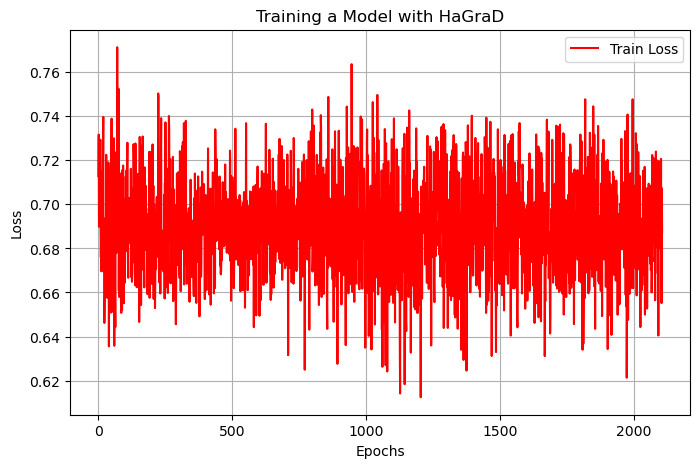

In [ ]:
fig = plt.figure(figsize=(8, 5))
plt.plot(loss_history, "-r", label="Train Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.title("Training a Model with HaGraD")
plt.show()